In [3]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from xhistogram.xarray import histogram
import scipy.stats
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# df = pd.read_excel('Coral_Locations.xlsx',engine='openpyxl')

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [4]:
locinit = "coral-approx"
timedir = "back"
runtime = 6*365 # days

fileout = ("output"
           +".locinit_"+locinit
           +".timedir_"+timedir
           +".ntime_"+str(runtime)+".nc")
fileout = "output.locinit_coral-approx.Np_50.timedir_back.ntime_2190.dt_360.itimes_N12_D6.nc"
ds = xr.open_dataset(fileout)

# ds['init_time'] = ds['time'].isel(obs=0)*xr.ones_like(ds['time'])
ds['init_lon'] = ds['lon'].isel(obs=0)*xr.ones_like(ds['lon'])
ds['init_lat'] = ds['lat'].isel(obs=0)*xr.ones_like(ds['lat'])
ds['init_z'] = ds['z'].isel(obs=0)*xr.ones_like(ds['z'])
ds['init_T'] = ds['T'].isel(obs=0)*xr.ones_like(ds['T'])
ds['init_S'] = ds['S'].isel(obs=0)*xr.ones_like(ds['S'])
dsall = ds.copy()

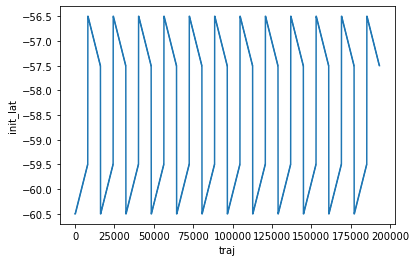

In [5]:
ds['init_lat'].isel(obs=0).plot()

In [6]:
sites = ['pink','green']
locs = {'pink':{'lat':[-60.5,-59.5],'depth':[-2000,-400]},
        'green':{'lat':[-57.5,-56.5],'depth':[-2000,-400]}}
conds = {}
for loc in locs.keys():
    latV = locs[loc]['lat']
    depthV = locs[loc]['depth']
    conds[loc] = ((ds['init_lat']>=latV[0])
                  &(ds['init_lat']<=latV[1]) 
                  &(ds['init_z']>=depthV[0])
                  &(ds['init_z']<=depthV[1]))
colors={}
for site in sites:
    colors[site] = 'tab:'+site

In [7]:
dssite = {}
for site in sites:
    dssite[site] = ds.where(conds[site]).dropna('traj')

In [8]:
def calc_jsd(p,q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """
    # from here https://medium.com/@sourcedexter/how-to-find-the-similarity-between-two-probability-distributions-using-python-a7546e90a08d
    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)
    # calculate m
    m = (p + q) / 2
    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
    # If two distribution differ only at level of machine precision,
    # set divergence to zero (to avoid negative numbers)
    if divergence<0:
        divergence = 0
    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)
    return distance

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2758: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)
<ipython-input-9-06465c98095a>:95: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


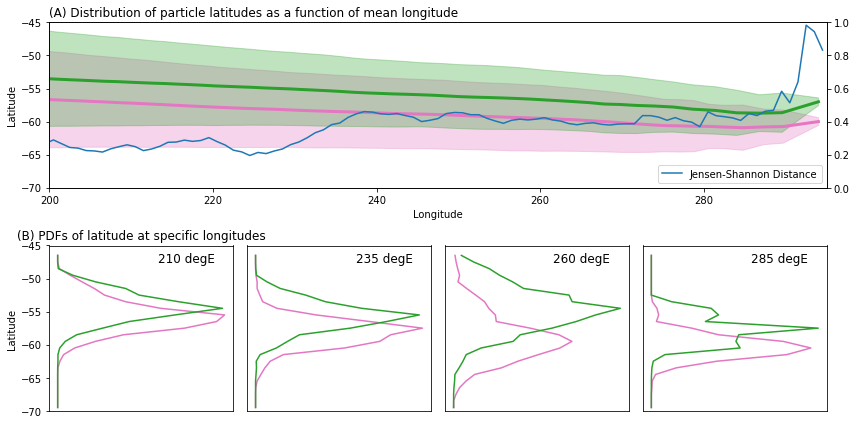

In [9]:
ystr = 'lat'

reslon = 1
lonG = np.arange(0,360,reslon)
if ystr=='lat':
    res = 1
    ylims = [-70,-45]
    sitesnow = sites
#     sitesnow = [sites[0],sites[2]]
elif ystr=='z':
    res = 50
    ylims = [-2500,0]
    sitesnow = sites
#     sitesnow = [sites[0],sites[1]]

yG = np.arange(ylims[0],ylims[1],res)


### CALCS
# Calculate histograms
hs = {}
for site in sitesnow:
    x = dssite[site]['lon']
    y = dssite[site][ystr]
    hs[site] = histogram(x,y,bins=[lonG,yG],block_size=1,density=True)
    hs[site] = hs[site].where((hs!=0))

lon_bins = hs[sitesnow[0]]['lon_bin']
jsd = np.zeros(len(lon_bins))
for i,l in enumerate(lon_bins):
    p = hs[sitesnow[0]].sel(lon_bin=l)
    q = hs[sitesnow[1]].sel(lon_bin=l)
    jsd[i] = np.array([calc_jsd(p,q)])

### PLOT
fig = plt.figure(constrained_layout=True,figsize=(12,6))
spec = fig.add_gridspec(2,4)
axu = fig.add_subplot(spec[0, :])
axl={}
axl[0] = fig.add_subplot(spec[1, 0])
axl[1]= fig.add_subplot(spec[1, 1])
axl[2] = fig.add_subplot(spec[1, 2])
axl[3] = fig.add_subplot(spec[1, 3])
# axjsd = fig.add_subplot(spec[2, :])

for site in sitesnow:
    if len(dssite[site]['traj'])==0:
        continue
    
    # Trajectories
    axnow = axu
    x = dssite[site]['lon'].mean('traj')
    y = dssite[site][ystr]
    ymax = y.mean('traj')+2*y.std('traj')
    ymin = y.mean('traj')-2*y.std('traj')
    
    axnow.plot(x,y.mean('traj'),color=colors[site],linewidth=3)
    axnow.fill_between(x,ymin,ymax,
                    color=colors[site],label=site,
                    alpha=0.3)
    
    # PDFs
    hsnow = hs[site]
    # Specific latitudes
    for i,lonT in enumerate(np.arange(210,301,25)):
        axnow = axl[i]
        axnow.plot(hsnow.sel(lon_bin=lonT,method='nearest'),hsnow[ystr+'_bin'],color=colors[site])
        if i!=0:
            axnow.set_yticks([])
        axnow.set_xticks([])
        axnow.set_ylim(ylims)
    
lonTs = np.arange(210,301,25)
for i,axnow in enumerate(axl.values()):
    xlims = axnow.get_xlim()
    dx = np.abs(np.diff(xlims))
    axnow.text(xlims[1]-dx/10,-47.5,str(lonTs[i])+' degE',horizontalalignment='right',fontsize=12)
    if i==0:
        axnow.set_title('(B) PDFs of latitude at specific longitudes') 
        axnow.set_ylabel('Latitude')
        
        
axu.set_xlim([200,295])
axu.set_ylim(ylims)
axu.set_title('(A) Distribution of particle latitudes as a function of mean longitude',loc='left')
axu.set_xlabel('Longitude')
axu.set_ylabel('Latitude')

# JSD
axj = axu.twinx()
axj.plot(lon_bins,jsd,zorder=0,label = 'Jensen-Shannon Distance')
axj.set_ylim([0,1])
axj.legend(loc='lower right')

fig.tight_layout()
fig.savefig('figures/coral_pdfs_'+ystr+'.png',dpi=300,transparent=True)

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2758: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/xarray/core/dataarray.py:3201: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


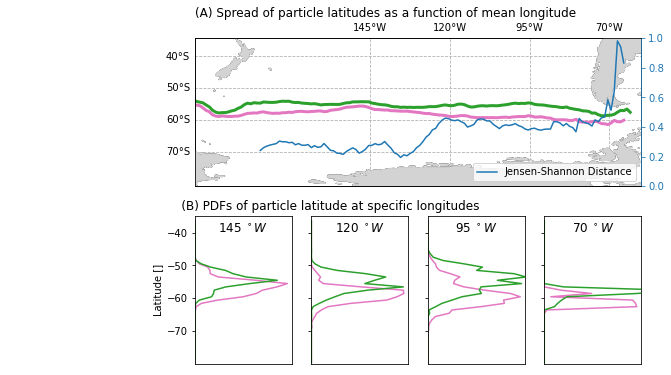

In [10]:
ystr = 'lat'

reslon = 1
lonG = np.arange(0,360,reslon)
res = 1
ylims = [-80,-35]
sitesnow = sites
yticks = [-40,-50,-60,-70]

yG = np.arange(ylims[0],ylims[1],res)

### CALCS
# Calculate histograms
hs = {}
for site in sitesnow:
    x = dssite[site]['lon']
    y = dssite[site][ystr]
    hs[site] = histogram(x,y,bins=[lonG,yG],block_size=1,density=True)
    hs[site] = hs[site].where((hs!=0))

lon_bins = hs[sitesnow[0]]['lon_bin']
jsd = np.zeros(len(lon_bins))
for i,l in enumerate(lon_bins):
    p = hs[sitesnow[0]].sel(lon_bin=l)
    q = hs[sitesnow[1]].sel(lon_bin=l)
    jsd[i] = np.array([calc_jsd(p,q)])

### PLOT
fig = plt.figure(constrained_layout=True,figsize=(8,6))
spec = fig.add_gridspec(2,4)
axu = fig.add_subplot(spec[0, :],projection=ccrs.PlateCarree(central_longitude=-100))
axu.set_extent([-200, -60, ylims[0], ylims[1]], ccrs.PlateCarree())
axu.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
axu.coastlines()

axl={}
axl[0] = fig.add_subplot(spec[1, 0])
axl[1]= fig.add_subplot(spec[1, 1])
axl[2] = fig.add_subplot(spec[1, 2])
axl[3] = fig.add_subplot(spec[1, 3])

lonTs = np.arange(215,301,25)

# Trajectories
for site in sitesnow:
    if len(dssite[site]['traj'])==0:
        continue
    
    axnow = axu
    x = dssite[site]['lon'].mean('traj')
    x = hs[site]['lon_bin']
    y = hs[site]['lat_bin'].weighted(hs[site]).mean('lat_bin')
#     ymax = y.mean('traj')+2*y.std('traj')
#     ymin = y.mean('traj')-2*y.std('traj')
#     ymax = y.max('traj')
#     ymin = y.min('traj')
    
#     axnow.plot(x,y.mean('traj'),color=colors[site],linewidth=3,
#               transform=ccrs.PlateCarree())
    axnow.plot(x,y,color=colors[site],linewidth=3,
              transform=ccrs.PlateCarree())    
#     axnow.fill_between(x,ymin,ymax,
#                        color=colors[site],label=site,
#                        alpha=0.3,
#                        transform=ccrs.PlateCarree())

axu.set_title('(A) Spread of particle latitudes as a function of mean longitude',loc='left')
# Add gridlines to map
gl = axu.gridlines(draw_labels=True,linestyle='--')
gl.bottom_labels = False
gl.xlocator = mticker.FixedLocator(lonTs-360)
gl.ylocator = mticker.FixedLocator(yticks)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# JSD
lonsnow = lon_bins.where((lon_bins>0)&(lon_bins<=180),lon_bins-360).roll(lon_bin=-180)+100
jsdnow = xr.DataArray(jsd,dims=['lon_bin']).roll(lon_bin=-180)
axj = axu.twinx()
axj.tick_params(axis='y',colors='tab:blue')
axj.spines["right"].set_edgecolor('tab:blue')
axj.plot(lonsnow,jsdnow,zorder=0,label = 'Jensen-Shannon Distance')
axj.set_ylim([0,1])
axj.legend(loc='lower right')


## PDFs
ylimsnow = axu.get_ylim()
for site in sitesnow:
    # PDFs
    hsnow = hs[site]
    # Specific longitudes
    for i,lonT in enumerate(lonTs):
        axnow = axl[i]
        axnow.plot(hsnow.sel(lon_bin=lonT,method='nearest'),hsnow[ystr+'_bin'],color=colors[site])
        axnow.set_yticks(yticks)
        if i!=0:
            axnow.set_yticklabels([])
        axnow.set_xticks([])
        axnow.set_ylim(ylimsnow)
        axnow.set_xlim(left=0)
        axnow.grid(axis='y',linestyle='--')
    
for i,axnow in enumerate(axl.values()):
    xlims = axnow.get_xlim()
    dx = np.abs(np.diff(xlims))
    axnow.text(xlims[1]-dx/2,ylims[1]-5,str(abs(lonTs[i]-360))+' $^\circ W$',horizontalalignment='center',fontsize=12)
    if i==0:
        axnow.set_title('                                             (B) PDFs of particle latitude at specific longitudes') 
        axnow.set_ylabel('Latitude []')
        
# # fig.savefig('figures/coral_pdfs_'+ystr+'.png',dpi=300,transparent=True)

In [11]:
# In fact, why not write a little function to get the statistics
def calc_stats_hs(hs,dim):
    """Calculate statistics of histogram bin values
    along specifed dimension. That is, the histogram counts/sums 
    provide the weights."""
    
    # Calculate statistics
    # (Could do further calculations here if desired)
    mean = hs[dim].weighted(hs).mean(dim)
    std = hs[dim].weighted(hs).std(dim)
    # Place in a xr.Dataset
    stats = xr.Dataset()
    stats['mean'] = mean
#     stats['std'] = std
    return stats

In [12]:
stats = calc_stats_hs(hs['pink'],dim='lat_bin')

AttributeError: 'DataArrayWeighted' object has no attribute 'std'

In [24]:
hs['pink'].weighted(hs['pink']).std()

AttributeError: 'DataArrayWeighted' object has no attribute 'std'

In [174]:
hs['pink']['histogram_lon_lat']

KeyError: 'histogram_lon_lat'

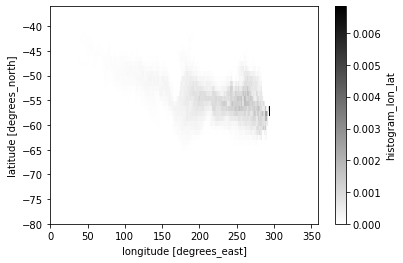

In [168]:
hs['green'].plot(x='lon_bin',cmap='gray_r')

In [118]:
lonsnow = lon_bins+100
lonsnow = lonsnow.where(lonsnow<360,lonsnow-360)
lonsnow

<xarray.DataArray 'lon_bin' (lon_bin: 359)>
array([100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5, 108.5,
       109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5, 117.5,
       118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5, 126.5,
       127.5, 128.5, 129.5, 130.5, 131.5, 132.5, 133.5, 134.5, 135.5,
       136.5, 137.5, 138.5, 139.5, 140.5, 141.5, 142.5, 143.5, 144.5,
       145.5, 146.5, 147.5, 148.5, 149.5, 150.5, 151.5, 152.5, 153.5,
       154.5, 155.5, 156.5, 157.5, 158.5, 159.5, 160.5, 161.5, 162.5,
       163.5, 164.5, 165.5, 166.5, 167.5, 168.5, 169.5, 170.5, 171.5,
       172.5, 173.5, 174.5, 175.5, 176.5, 177.5, 178.5, 179.5, 180.5,
       181.5, 182.5, 183.5, 184.5, 185.5, 186.5, 187.5, 188.5, 189.5,
       190.5, 191.5, 192.5, 193.5, 194.5, 195.5, 196.5, 197.5, 198.5,
       199.5, 200.5, 201.5, 202.5, 203.5, 204.5, 205.5, 206.5, 207.5,
       208.5, 209.5, 210.5, 211.5, 212.5, 213.5, 214.5, 215.5, 216.5,
       217.5, 218.5, 219.5, 220.5, 221.5, 222.5, 223.5, 224.5, 225.5,
       226.5, 227.5, 228.5, 229.5, 230.5, 231.5, 232.5, 233.5, 234.5,
       235.5, 236.5, 237.5, 238.5, 239.5, 240.5, 241.5, 242.5, 243.5,
       244.5, 245.5, 246.5, 247.5, 248.5, 249.5, 250.5, 251.5, 252.5,
       253.5, 254.5, 255.5, 256.5, 257.5, 258.5, 259.5, 260.5, 261.5,
       262.5, 263.5, 264.5, 265.5, 266.5, 267.5, 268.5, 269.5, 270.5,
       271.5, 272.5, 273.5, 274.5, 275.5, 276.5, 277.5, 278.5, 279.5,
       280.5, 281.5, 282.5, 283.5, 284.5, 285.5, 286.5, 287.5, 288.5,
       289.5, 290.5, 291.5, 292.5, 293.5, 294.5, 295.5, 296.5, 297.5,
       298.5, 299.5, 300.5, 301.5, 302.5, 303.5, 304.5, 305.5, 306.5,
       307.5, 308.5, 309.5, 310.5, 311.5, 312.5, 313.5, 314.5, 315.5,
       316.5, 317.5, 318.5, 319.5, 320.5, 321.5, 322.5, 323.5, 324.5,
       325.5, 326.5, 327.5, 328.5, 329.5, 330.5, 331.5, 332.5, 333.5,
       334.5, 335.5, 336.5, 337.5, 338.5, 339.5, 340.5, 341.5, 342.5,
       343.5, 344.5, 345.5, 346.5, 347.5, 348.5, 349.5, 350.5, 351.5,
       352.5, 353.5, 354.5, 355.5, 356.5, 357.5, 358.5, 359.5,   0.5,
         1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,
        19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,
        28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,
        37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,  45.5,
        46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,  54.5,
        55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,  63.5,
        64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,  72.5,
        73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,  81.5,
        82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,  90.5,
        91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5])
Coordinates:
  * lon_bin  (lon_bin) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5

In [92]:
lons=lon_bins.where((lon_bins>0)&(lon_bins<180),lon_bins-360)
lons

<xarray.DataArray 'lon_bin' (lon_bin: 359)>
array([   0.5,    1.5,    2.5,    3.5,    4.5,    5.5,    6.5,    7.5,
          8.5,    9.5,   10.5,   11.5,   12.5,   13.5,   14.5,   15.5,
         16.5,   17.5,   18.5,   19.5,   20.5,   21.5,   22.5,   23.5,
         24.5,   25.5,   26.5,   27.5,   28.5,   29.5,   30.5,   31.5,
         32.5,   33.5,   34.5,   35.5,   36.5,   37.5,   38.5,   39.5,
         40.5,   41.5,   42.5,   43.5,   44.5,   45.5,   46.5,   47.5,
         48.5,   49.5,   50.5,   51.5,   52.5,   53.5,   54.5,   55.5,
         56.5,   57.5,   58.5,   59.5,   60.5,   61.5,   62.5,   63.5,
         64.5,   65.5,   66.5,   67.5,   68.5,   69.5,   70.5,   71.5,
         72.5,   73.5,   74.5,   75.5,   76.5,   77.5,   78.5,   79.5,
         80.5,   81.5,   82.5,   83.5,   84.5,   85.5,   86.5,   87.5,
         88.5,   89.5,   90.5,   91.5,   92.5,   93.5,   94.5,   95.5,
         96.5,   97.5,   98.5,   99.5,  100.5,  101.5,  102.5,  103.5,
        104.5,  105.5,  106.5,  107.5,  108.5,  109.5,  110.5,  111.5,
        112.5,  113.5,  114.5,  115.5,  116.5,  117.5,  118.5,  119.5,
        120.5,  121.5,  122.5,  123.5,  124.5,  125.5,  126.5,  127.5,
        128.5,  129.5,  130.5,  131.5,  132.5,  133.5,  134.5,  135.5,
        136.5,  137.5,  138.5,  139.5,  140.5,  141.5,  142.5,  143.5,
        144.5,  145.5,  146.5,  147.5,  148.5,  149.5,  150.5,  151.5,
        152.5,  153.5,  154.5,  155.5,  156.5,  157.5,  158.5,  159.5,
...
       -159.5, -158.5, -157.5, -156.5, -155.5, -154.5, -153.5, -152.5,
       -151.5, -150.5, -149.5, -148.5, -147.5, -146.5, -145.5, -144.5,
       -143.5, -142.5, -141.5, -140.5, -139.5, -138.5, -137.5, -136.5,
       -135.5, -134.5, -133.5, -132.5, -131.5, -130.5, -129.5, -128.5,
       -127.5, -126.5, -125.5, -124.5, -123.5, -122.5, -121.5, -120.5,
       -119.5, -118.5, -117.5, -116.5, -115.5, -114.5, -113.5, -112.5,
       -111.5, -110.5, -109.5, -108.5, -107.5, -106.5, -105.5, -104.5,
       -103.5, -102.5, -101.5, -100.5,  -99.5,  -98.5,  -97.5,  -96.5,
        -95.5,  -94.5,  -93.5,  -92.5,  -91.5,  -90.5,  -89.5,  -88.5,
        -87.5,  -86.5,  -85.5,  -84.5,  -83.5,  -82.5,  -81.5,  -80.5,
        -79.5,  -78.5,  -77.5,  -76.5,  -75.5,  -74.5,  -73.5,  -72.5,
        -71.5,  -70.5,  -69.5,  -68.5,  -67.5,  -66.5,  -65.5,  -64.5,
        -63.5,  -62.5,  -61.5,  -60.5,  -59.5,  -58.5,  -57.5,  -56.5,
        -55.5,  -54.5,  -53.5,  -52.5,  -51.5,  -50.5,  -49.5,  -48.5,
        -47.5,  -46.5,  -45.5,  -44.5,  -43.5,  -42.5,  -41.5,  -40.5,
        -39.5,  -38.5,  -37.5,  -36.5,  -35.5,  -34.5,  -33.5,  -32.5,
        -31.5,  -30.5,  -29.5,  -28.5,  -27.5,  -26.5,  -25.5,  -24.5,
        -23.5,  -22.5,  -21.5,  -20.5,  -19.5,  -18.5,  -17.5,  -16.5,
        -15.5,  -14.5,  -13.5,  -12.5,  -11.5,  -10.5,   -9.5,   -8.5,
         -7.5,   -6.5,   -5.5,   -4.5,   -3.5,   -2.5,   -1.5])
Coordinates:
  * lon_bin  (lon_bin) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5
Attributes:
    long_name:      
    standard_name:  longitude
    units:          degrees_east
    axis:           X

(200.0, 300.0)

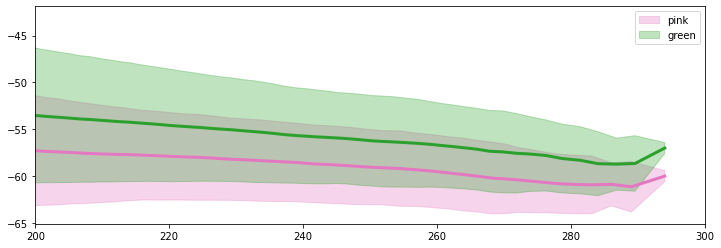

In [9]:
fig,ax = plt.subplots(figsize=(12,4))

for site in [sites[0],sites[2]]:
    if len(dssite[site]['traj'])==0:
        continue
    x = dssite[site]['lon'].mean('traj')
#     x = dssite[site]['time'].isel(traj=0).values
    y = dssite[site]['lat']
    ymax = y.mean('traj')+2*y.std('traj')
    ymin = y.mean('traj')-2*y.std('traj')
    
    ax.plot(x,y.mean('traj'),color=colors[site],linewidth=3)
    ax.fill_between(x,ymin,ymax,
                    color=colors[site],label=site,
                    alpha=0.3)
ax.legend()
ax.set_xlim([200,300])

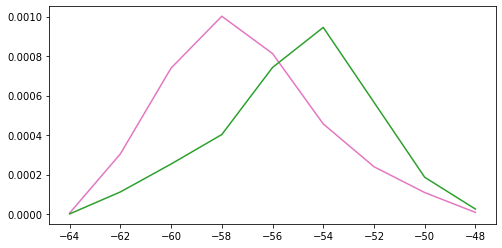

In [10]:
res = 2
lonG = np.arange(0,360,res)
latG = np.arange(-75,-45,res)
lonT = 200
fig,ax = plt.subplots(figsize=(8,4))
for site in [sites[0],sites[2]]:
    x = dssite[site]['lon']
    y = dssite[site]['lat']
    hs = histogram(x,y,bins=[lonG,latG],block_size=1,density=True)
    hs = hs.where((hs!=0))
    ax.plot(hs['lat_bin'],hs.sel(lon_bin=lonT,method='nearest'),color=colors[site])

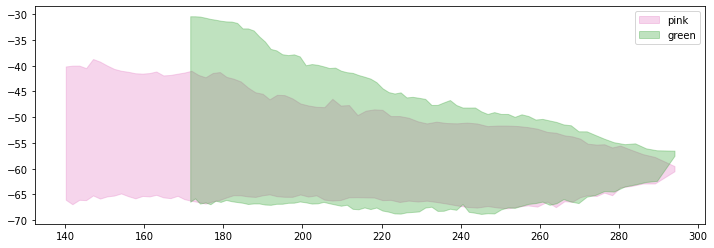

In [11]:
fig,ax = plt.subplots(figsize=(12,4))

for site in [sites[0],sites[2]]:
    if len(dssite[site]['traj'])==0:
        continue
    x = dssite[site]['lon'].mean('traj')
#     x = dssite[site]['time'].isel(traj=0).values
    y = dssite[site]['lat']
    ymax = y.max('traj')
    ymin = y.min('traj')
    
    ax.fill_between(x,ymin,ymax,
                    color=colors[site],label=site,
                    alpha=0.3)
ax.legend()

In [34]:
# Wrapper for southern ocean map
def plt_SO(max_lat=-45, central_longitude=-100):
    """Configure polar stereographic projection for Southern Ocean.
    In particular, sets extent of axis and cuts a circular boundary.
    Returns figure and axis handles into which you can plot.
    
    Parameters
    ----------
    max_lat : float, int
        Northernmost latitude in degN
    central_longitude : float, int
        Longitude to place at top of figure
    
    Returns
    -------
    fig : mpl figure handle
    ax : mpl axis handle
    """
    fig,ax = plt.subplots(figsize=(20,10),
                      subplot_kw={'projection':
                                      ccrs.SouthPolarStereo(
                                      central_longitude=-100)})
    ax.set_extent([-180, 180, -90, max_lat], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Add some details
    ax.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
    ax.gridlines()
    
    return fig,ax

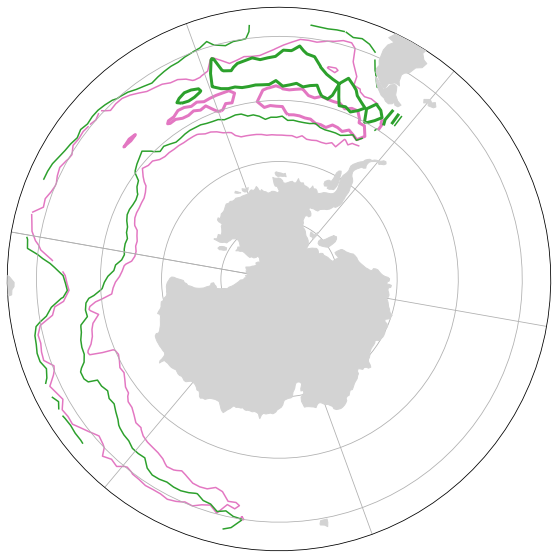

In [35]:
res = 2
lonG = np.arange(0,360,res)
latG = np.arange(-75,-45,res)
fig,ax = plt_SO()
for site in sites:
    x = dssite[site]['lon']
    y = dssite[site]['lat']
    hs = histogram(x,y,bins=[lonG,latG],block_size=1,density=True)
    hs = hs.where((hs!=0))
    ax.contour(hs['lon_bin'],hs['lat_bin'],
                hs.transpose(),levels=np.array([0.0001]),
                transform=ccrs.PlateCarree(),colors=colors[site])
    ax.contour(hs['lon_bin'],hs['lat_bin'],
                hs.transpose(),levels=np.array([0.001]),
                transform=ccrs.PlateCarree(),colors=colors[site],linewidths=3)
#     im.set_clim([0,100])

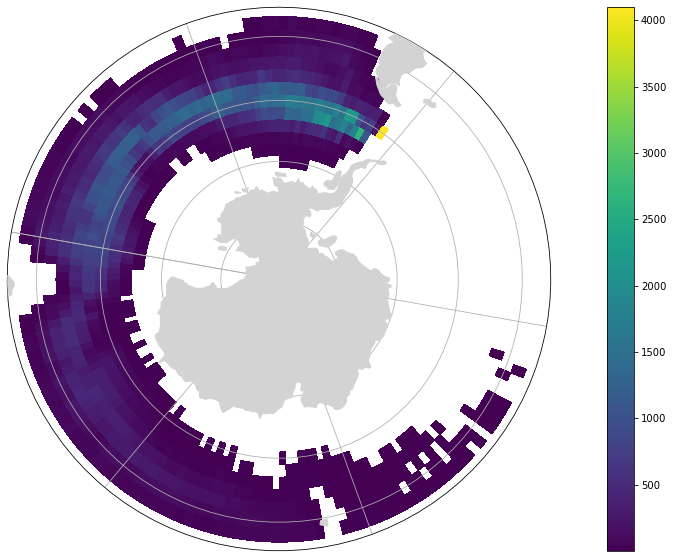

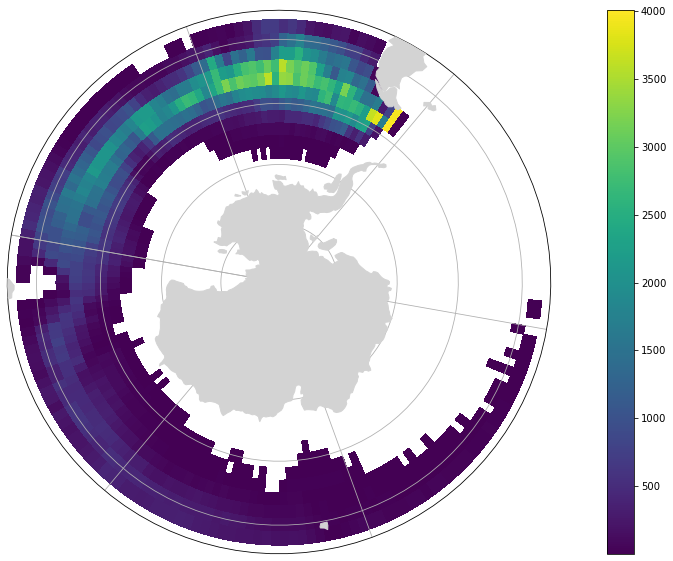

In [36]:
res = 2
lonG = np.arange(0,360,res)
latG = np.arange(-75,-45,res)
for site in sites:
    fig,ax = plt_SO()
    x = dssite[site]['lon']
    y = dssite[site]['lat']
    hs = histogram(x,y,bins=[lonG,latG],block_size=1)
    hs = hs.where((hs!=0))
    im=ax.pcolormesh(hs['lon_bin'],hs['lat_bin'],
                     hs.transpose(),
                     transform=ccrs.PlateCarree())
#     im.set_clim([0,100])
    plt.colorbar(im,ax=ax)

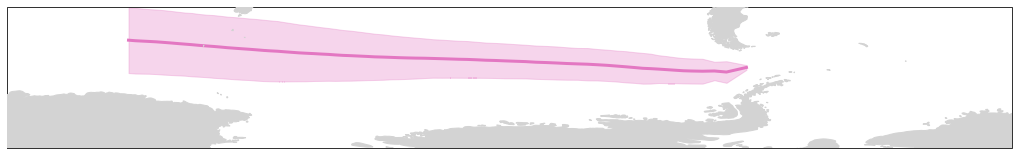

In [27]:
fig,ax = plt.subplots(figsize=(18,6),
                      subplot_kw={'projection':
                                      ccrs.PlateCarree(
                                      central_longitude=-100)})
ax.set_extent([-250, 0, -80, -45], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
site='pink'
x = dssite[site]['lon'].mean('traj')
y = dssite[site]['lat']
ymax = y.mean('traj')+2*y.std('traj')
ymin = y.mean('traj')-2*y.std('traj')
    
ax.plot(x,y.mean('traj'),color=colors[site],linewidth=3,transform=ccrs.PlateCarree())
ax.fill_between(x,ymin,ymax,
                    color=colors[site],label=site,
                    alpha=0.3,
                    transform=ccrs.PlateCarree())

In [19]:
x

<xarray.DataArray 'lon' (obs: 74)>
array([294.     , 289.0246 , 286.02466, 283.0654 , 280.29388, 278.24884,
       276.25638, 274.29703, 272.06335, 270.14905, 268.17987, 266.1995 ,
       264.01636, 261.86752, 259.3157 , 256.95987, 254.43646, 251.90916,
       249.2959 , 246.76523, 244.1134 , 241.56459, 238.98499, 236.40768,
       233.84773, 231.41505, 229.13838, 226.83061, 224.54703, 222.2891 ,
       220.20042, 218.11127, 215.98387, 213.90767, 211.74199, 209.65297,
       207.54893, 205.54071, 203.51859, 201.46634, 199.45473, 197.42236,
       195.44588, 193.55037, 191.68536, 189.94647, 188.11232, 186.26059,
       184.38689, 182.5776 , 180.821  , 179.12296, 177.33217, 175.49915,
       173.72664, 171.96205, 170.1948 , 168.45473, 166.66681, 164.84772,
       163.065  , 161.35814, 159.6051 , 157.78584, 155.96742, 154.18636,
       152.42363, 150.61115, 148.85435, 147.09169, 145.33644, 143.60677,
       141.86629, 140.19516], dtype=float32)
Dimensions without coordinates: obs

In [29]:
import bsose.preprocess as pp
import copy
import matplotlib.cm as cm

In [22]:
dsb,xgrid = pp.load_bsose()

In [39]:
lonV = 360-69
varstr='THETA'
iselect = {"time":-1}
selectslice = {"YC":slice(-75,-50)}
select = {"XC":lonV}
da = dsb[varstr].isel(
    **iselect).sel(
    **select,method='nearest').sel(
    **selectslice)
da_masked = np.ma.masked_where(da==0,da)

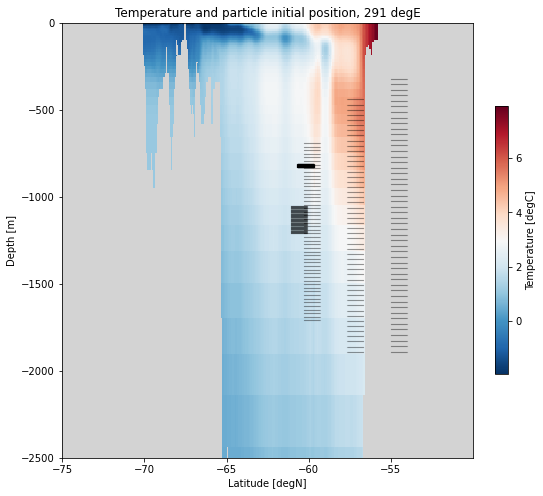

In [40]:
fig,ax = plt.subplots(figsize=(8,8))
cmap = copy.copy(cm.RdBu_r)
cmap.set_bad('lightgray')
im = ax.pcolormesh(da['YC'],da['Z'],da_masked,shading='auto',cmap=cmap)
lats = ds['init_lat'].isel(obs=0)
depths = ds['init_z'].isel(obs=0)
ax.plot(lats,
        depths,
        linestyle='None',
        marker='.',
        color='k',
        markersize=0.1)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degN]')
ax.set_title('Temperature and particle initial position, %s degE' %str(lonV))
ax.set_ylim([depthV[0]-500,0])
plt.colorbar(im,ax=ax,
             fraction=0.03,pad=0.05,
             label='Temperature [degC]')

,Coral Sites,names,Latitude,Longitude,Depth,Unnamed: 5
0,Burdwood Bank (BB),BB,54.500000,62.166667,334.0,NaN
1,Burdwood Bank (BB),BB,54.500000,62.166667,727.0,NaN
2,Burdwood Bank (BB),BB,54.500000,62.166667,816.0,NaN
3,Burdwood Bank (BB),BB,54.500000,62.166667,1419.0,NaN
4,Burdwood Bank (BB),BB,54.500000,62.166667,1879.0,NaN
5,Cape Horn (CH),CH,57.166667,66.100000,450.0,NaN
6,Cape Horn (CH),CH,57.166667,66.100000,1012.0,NaN
7,Cape Horn (CH),CH,57.166667,66.100000,1214.0,NaN
8,Cape Horn (CH),CH,57.166667,66.100000,1441.0,NaN
9,Cape Horn (CH),CH,57.166667,66.100000,1877.0,NaN
